In [1]:
# import libraries 

import numpy as np
import cv2 as cv
import pandas as pd
from skimage.filters import roberts, sobel, scharr, prewitt
from scipy import ndimage as nd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import pickle
import matplotlib.pyplot as plt

In [3]:
# Reading an image
img = cv.imread('Resources/Train_images/Sandstone_Versa0000.tif', 0)
img2= img.reshape(-1)

## Creating the dataframe and adding the features


In [4]:
df = pd.DataFrame()

df['Original Image'] = img2# Feature #1 (Original pixel value)

# Gabor features
ksize = 5
phi = 0
num = 1 # count for labelling
kernels = []
for theta in range(2): #Define number of thetas
    theta = theta /4. *np.pi
    for sigma in (1,3): #Sigma with 1 and 3
        for lamda in np.arange(0, np.pi, np.pi/4): #Range of wavelengths
            for gamma in (0.05, 0.5): # Gamma values of 0.05 and 0.5
                gabor_label ='Gabor' + str(num)
                kernel = cv.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv.CV_32F)
                kernels.append(kernel)
                fimg = cv.filter2D(img,cv.CV_8UC3, kernel)
                filtered_img = fimg.reshape(-1)
                df[gabor_label] = filtered_img
                num += 1
                
# Canny Edge Feature
edges = cv.Canny(img, 100,200).reshape(-1)
df['Canny Edge'] = edges

# Roberts Feature 
edge_roberts = roberts(img)
edge_roberts1 = edge_roberts.reshape(-1)
df['Roberts'] = edge_roberts1

# Sobel Feature
sobel_img = sobel(img)
sobel1 = sobel_img.reshape(-1)
df['Sobel'] = sobel1


# Scharr Feature 
edge_scharr = scharr(img)
edge_scharr1 = edge_scharr.reshape(-1)
df['Scharr'] = edge_scharr1

# Prewitt Feature 
edge_prewitt = prewitt(img)
edge_prewitt1 = edge_prewitt.reshape(-1)
df['Prewitt'] = edge_prewitt1

#Gaussian Features
gaussian_img = nd.gaussian_filter(img, sigma=3)
gaussian1 = gaussian_img.reshape(-1)
df['Gaussian s3'] = gaussian1

gaussian_img2 = nd.gaussian_filter(img, sigma=7)
gaussian3 = gaussian_img.reshape(-1)
df['Gaussian s7'] = gaussian3

# Median Feature
median_img = nd.median_filter(img, size=3)
median_img1 = median_img.reshape(-1)
df['Median s3'] = median_img1

# Variance Feature
variance_img = nd.generic_filter(img, np.var, size=3)
variance_img1 = variance_img.reshape(-1)
df['Variance s3'] = variance_img1

In [5]:
# Adding the labeled image
labeled_img = cv.imread('Resources/Train_masks/Sandstone_Versa0000.tif', 0)
labeled_img1 = labeled_img.reshape(-1)
df['Labels'] = labeled_img1

In [6]:
# Splitting the data 
y = df['Labels'].values
x = df.drop(['Labels'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4, random_state=20)

## Train the model

In [7]:
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(x_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

## Prediction

In [8]:
prediction_test = model.predict(x_test)
print('Accuracy: ', metrics.accuracy_score(y_test, prediction_test))

Accuracy:  0.976995406434913


## Feature Ranking

In [9]:
importances = list(model.feature_importances_)
features_list = list(x.columns)
features_importance = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)
print(features_importance)

Gaussian s3       2.517604e-01
Gabor4            1.574089e-01
Median s3         1.179338e-01
Original Image    1.105636e-01
Gabor23           8.106294e-02
Gabor24           7.557426e-02
Gabor29           6.942098e-02
Gaussian s7       2.819593e-02
Gabor3            1.667161e-02
Gabor16           1.482637e-02
Prewitt           1.088471e-02
Gabor21           8.046499e-03
Sobel             7.857437e-03
Gabor15           7.517661e-03
Scharr            6.695269e-03
Gabor30           5.498937e-03
Gabor5            5.159834e-03
Roberts           4.350865e-03
Gabor6            3.610810e-03
Gabor31           3.126133e-03
Gabor32           2.961885e-03
Variance s3       2.792397e-03
Gabor7            2.558351e-03
Gabor8            2.493910e-03
Gabor22           1.927621e-03
Canny Edge        1.004794e-03
Gabor12           5.154392e-05
Gabor20           1.671275e-05
Gabor11           1.589392e-05
Gabor27           7.532661e-06
Gabor28           9.694201e-07
Gabor19           9.615404e-07
Gabor14 

## Pickling the model (storing the model)

In [10]:
filename = 'Results/sandstone_RF_model'
pickle.dump(model, open(filename, 'wb'))

## Loading the model and use it

In [11]:
load_model = pickle.load(open(filename, 'rb'))
result = load_model.predict(x)

In [12]:
segmented = result.reshape(img.shape) #Reshaping the results

## Plotting the results

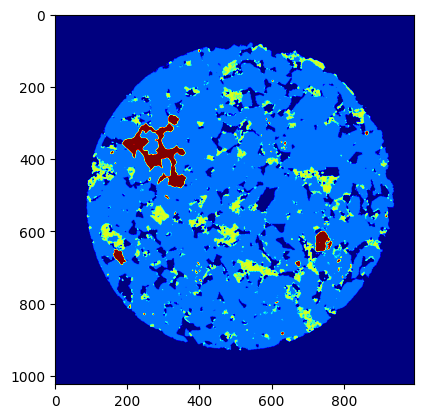

In [13]:
plt.imshow(segmented, cmap='jet')
plt.imsave('Results/segmented_rock.jpg', segmented, cmap='jet')

## Segmenting multiple images

In [14]:
import glob

def feature_extraction(img):
    
    ### Creating the dataframe and adding the features
    df = pd.DataFrame()
    
    img2= img.reshape(-1)
    df['Original Image'] = img2# Feature #1 (Original pixel value)
    
    #### Gabor features
    ksize = 5
    phi = 0
    num = 1 # count for labelling
    kernels = []
    for theta in range(2): #Define number of thetas
        theta = theta /4. *np.pi
        for sigma in (1,3): #Sigma with 1 and 3
            for lamda in np.arange(0, np.pi, np.pi/4): #Range of wavelengths
                for gamma in (0.05, 0.5): # Gamma values of 0.05 and 0.5
                    gabor_label ='Gabor' + str(num)
                    kernel = cv.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv.CV_32F)
                    kernels.append(kernel)
                    fimg = cv.filter2D(img,cv.CV_8UC3, kernel)
                    filtered_img = fimg.reshape(-1)
                    df[gabor_label] = filtered_img
                    num += 1
                    
    
    ### Canny Edge Feature
    edges = cv.Canny(img, 100,200).reshape(-1)
    df['Canny Edge'] = edges
    
    ### Roberts Feature 
    edge_roberts = roberts(img)
    edge_roberts1 = edge_roberts.reshape(-1)
    df['Roberts'] = edge_roberts1
    
    ##### Sobel Feature
    sobel_img = sobel(img)
    sobel1 = sobel_img.reshape(-1)
    df['Sobel'] = sobel1
    
    
    #### Scharr Feature 
    edge_scharr = scharr(img)
    edge_scharr1 = edge_scharr.reshape(-1)
    df['Scharr'] = edge_scharr1
    
    #### Prewitt Feature 
    edge_prewitt = prewitt(img)
    edge_prewitt1 = edge_prewitt.reshape(-1)
    df['Prewitt'] = edge_prewitt1
    
    ###Gaussian Features
    gaussian_img = nd.gaussian_filter(img, sigma=3)
    gaussian1 = gaussian_img.reshape(-1)
    df['Gaussian s3'] = gaussian1
    
    gaussian_img2 = nd.gaussian_filter(img, sigma=7)
    gaussian3 = gaussian_img.reshape(-1)
    df['Gaussian s7'] = gaussian3
    
    #### Median Feature
    median_img = nd.median_filter(img, size=3)
    median_img1 = median_img.reshape(-1)
    df['Median s3'] = median_img1
    
    ### Variance Feature
    variance_img = nd.generic_filter(img, np.var, size=3)
    variance_img1 = variance_img.reshape(-1)
    df['Variance s3'] = variance_img1
    
    return df

In [16]:
filename = 'Results/sandstone_RF_model'
load_model = pickle.load(open(filename, 'rb'))

In [17]:
path = 'Resources/Train_images/*.tif'
for file in glob.glob(path):
    #print(file)
    img1=cv.imread(file)
    img = cv.cvtColor(img1, cv.COLOR_BGR2GRAY)
    
    x = feature_extraction(img)
    result = load_model.predict(x)
    segmented = result.reshape((img.shape))
    name = file.split('e_')
    plt.imsave('Results/Segmented/' + name[1], segmented, cmap='jet', format='png')